In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input
import numpy as np
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports MDN
import matplotlib.pyplot as plt
%matplotlib inline

input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

Using TensorFlow backend.


In [2]:
# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

## Helper functions for touchscreen performances

We need a few helper functions for managing performances:
    
- Convert performances to and from pandas dataframes.
- Generate random touches.
- Sample whole performances from scratch and from a priming performance.
- Plot performances including dividing into swipes.

In [3]:
SCALE_FACTOR = 10  # scales input and output from the model. Should be the same between training and inference.


def perf_df_to_array(perf_df):
    """Converts a dataframe of a performance into array a,b,dt format."""
    perf_df['dt'] = perf_df.time.diff()
    perf_df.dt = perf_df.dt.fillna(0.0)
    # Clean performance data
    # Tiny Performance bounds defined to be in [[0,1],[0,1]], edit to fix this.
    perf_df.at[perf_df[perf_df.dt > 5].index, 'dt'] = 5.0
    perf_df.at[perf_df[perf_df.dt < 0].index, 'dt'] = 0.0
    perf_df.at[perf_df[perf_df.x > 1].index, 'x'] = 1.0
    perf_df.at[perf_df[perf_df.x < 0].index, 'x'] = 0.0
    perf_df.at[perf_df[perf_df.y > 1].index, 'y'] = 1.0
    perf_df.at[perf_df[perf_df.y < 0].index, 'y'] = 0.0
    return np.array(perf_df[['x', 'y', 'dt']])


def perf_array_to_df(perf_array):
    """Converts an array of a performance (a,b,dt format) into a dataframe."""
    perf_array = perf_array.T
    perf_df = pd.DataFrame({'x': perf_array[0], 'y': perf_array[1], 'dt': perf_array[2]})
    perf_df['time'] = perf_df.dt.cumsum()
    perf_df['z'] = 38.0
    # As a rule of thumb, could classify taps with dt>0.1 as taps, dt<0.1 as moving touches.
    perf_df['moving'] = 1
    perf_df.at[perf_df[perf_df.dt > 0.1].index, 'moving'] = 0
    perf_df = perf_df.set_index(['time'])
    return perf_df[['x', 'y', 'z', 'moving']]


def random_touch():
    """Generate a random tiny performance touch."""
    return np.array([np.random.rand(), np.random.rand(), 0.01])


def constrain_touch(touch):
    """Constrain touch values from the MDRNN"""
    touch[0] = min(max(touch[0], 0.0), 1.0)  # x in [0,1]
    touch[1] = min(max(touch[1], 0.0), 1.0)  # y in [0,1]
    touch[2] = max(touch[2], 0.001)  # dt # define minimum time step
    return touch

def generate_random_tiny_performance(model, n_mixtures, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0):
    """Generates a tiny performance up to 5 seconds in length."""
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        performance.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)


def condition_and_generate(model, perf, n_mixtures, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0):
    """Conditions the network on an existing tiny performance, then generates a new one."""
    time = 0
    steps = 0
    # condition
    for touch in perf:
        params = model.predict(touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output = [previous_touch.reshape((3,))]
    # generate
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        output.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    net_output = np.array(output)
    return net_output

def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

def plot_2D(perf_df, name="foo", saving=False):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_double_2d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 2D"""
    plt.figure(figsize=(8, 8))
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Load up the Dataset:

The dataset consists of around 1000 5-second performances from the MicroJam app.

This is in a sequence of points consisting of an x-location, a y-location, and a time-delta from the previous point.

When the user swipes, the time-delta is very small, if they tap it's quite large.

Let's have a look at some of the data:

In [4]:
### Test Loading from the saved datafile.
with np.load('../datasets/tiny_performance_datasets.npz') as loaded:
    loaded_raw = loaded['raw_perfs']
    loaded_diff = loaded['diff_perfs']
    
print("Loaded perfs:", len(loaded_raw), "and", len(loaded_diff))
print("Num touches:", np.sum([len(l) for l in loaded_raw]))

corpus = []

for l in loaded_raw:
    corpus.append(l[:,:-1])


Loaded perfs: 1394 and 1394
Num touches: 219582


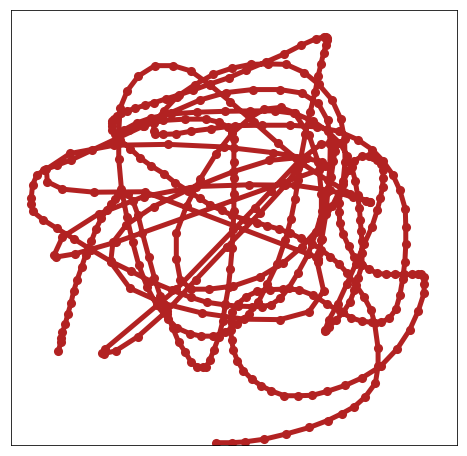

In [10]:
# Plot a bit of the data to have a look:
plot_2D(perf_array_to_df(random.choice(corpus)))

# Define the RNN

In [23]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 512
EPOCHS = 100
VAL_SPLIT=0.10

# Set random seed for reproducibility
SEED = 2345  
random.seed(SEED)
np.random.seed(SEED)

def batch_generator(seq_len, batch_size, dim, corpus):
    # Create empty arrays to contain batch of features and labels#
    batch_X = np.zeros((batch_size, seq_len, dim))
    batch_y = np.zeros((batch_size, dim))
    while True:
        for i in range(batch_size):
            # choose random example
            l = random.choice(corpus)
            last_index = len(l) - seq_len - 1
            start_index = np.random.randint(0, high=last_index)
            batch_X[i] = l[start_index:start_index+seq_len]
            batch_y[i] = l[start_index+1:start_index+seq_len+1] #.reshape(1,dim)
        yield batch_X, batch_y    

# Restrict corpus to sequences longer than the corpus.
corpus = [l for l in corpus if len(l) > SEQ_LEN+1]
print("Corpus Examples:", len(corpus))
# Produce the generator for training
generator = batch_generator(SEQ_LEN, BATCH_SIZE, 3, corpus)

# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_overlapping_format(examples):
    """Takes sequences of seq_len+1 and returns overlapping
    sequences of seq_len."""
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[1:])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in corpus:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_overlapping_format(slices)

X = np.array(X) * SCALE_FACTOR
y = np.array(y) * SCALE_FACTOR

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Corpus Examples: 1175
Number of training examples:
X: (178513, 30, 3)
y: (178513, 30, 3)


In [24]:
print(X[0,0])

[1.31836 0.85938 0.     ]


Now let's set up the model:

In [26]:
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 5

inputs = keras.layers.Input(shape=(SEQ_LEN,OUTPUT_DIMENSION), name='inputs')
lstm1_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm1', return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(HIDDEN_UNITS, name='lstm2', return_sequences=True)(lstm1_out)
mdn_out = keras.layers.TimeDistributed(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES, name='mdn_outputs'), name='td_mdn')(lstm2_out)

model = keras.models.Model(inputs=inputs, outputs=mdn_out)
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer='adam') #keras.optimizers.Adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30, 3)             0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 30, 512)           1056768   
_________________________________________________________________
lstm2 (LSTM)                 (None, 30, 512)           2099200   
_________________________________________________________________
td_mdn (TimeDistributed)     (None, 30, 35)            17955     
Total params: 3,173,923
Trainable params: 3,173,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 5

def build_robojam_model(seq_len=30, hidden_units=256, num_mixtures=5, layers=2, time_dist=True, compile_model=True, print_summary=True):
    print("Building RoboJam Model...")
    out_dim = 3
    inputs = keras.layers.Input(shape=(seq_len,out_dim), name='inputs')
    lstm_in = inputs # starter input for lstm
    for layer_i in range(layers):
        ret_seq = True
        if (layer_i == layers - 1) && !time_dist:
            # return sequences false if last layer, and not time distributed.
            ret_seq = False
        lstm_out = keras.layers.LSTM(hidden_uits, name='lstm'+str(layer_i), return_sequences=ret_seq)(lstm_in)
        lstm_in = lstm_out
    
    mdn_layer = mdn.MDN(out_dim, num_mixtures, name='mdn_outputs')
    if time_dist:
        mdn_layer = keras.layers.TimeDistributed(mdn_layer, name='td_mdn')
    mdn_out = mdn_layer(lstm_out)  # apply mdn
    model = keras.models.Model(inputs=inputs, outputs=mdn_out)
    
    if compile_model:
        loss_func = mdn.get_mixture_loss_func(out_dim,num_mixtures)
        optimizer = keras.optimizers.Adam() # keras.optimizers.Adam(lr=0.0001))
        model.compile(loss=loss_func, optimizer=optimizer)

    model.summary()
    return model

In [ ]:
# OUTPUT_DIMENSION = 3
# NUMBER_MIXTURES = 5

# model = keras.Sequential()
# model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
# model.add(keras.layers.LSTM(HIDDEN_UNITS))
# model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
# model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam(lr=0.0001))
# model.summary()

In [ ]:
#keras.utils.plot_model(model)

## Training

In [ ]:
# Train the model
filepath="robojam-td-model-E{epoch:02d}-VL{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
terminateOnNaN = keras.callbacks.TerminateOnNaN()
tboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[checkpoint,terminateOnNaN])
#history = model.fit_generator(generator, steps_per_epoch=300, epochs=100, verbose=1, initial_epoch=0)


# Save the Model
#model.save('robojam-mdn-rnn.h5')  # creates a HDF5 file of the model
model.save('robojam-td-mdn-rnn-final.h5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


Train on 160661 samples, validate on 17852 samples
Epoch 1/100
160661/160661 [==============================] - 128s 798us/step - loss: 6.3036 - val_loss: 4.7066

Epoch 00001: val_loss improved from inf to 4.70658, saving model to robojam-td-model-E01-VL4.71.hdf5
Epoch 2/100
160661/160661 [==============================] - 119s 742us/step - loss: 1.6792 - val_loss: 1.0178

Epoch 00002: val_loss improved from 4.70658 to 1.01778, saving model to robojam-td-model-E02-VL1.02.hdf5
Epoch 3/100
160661/160661 [==============================] - 126s 783us/step - loss: -0.3947 - val_loss: -2.6726

Epoch 00003: val_loss improved from 1.01778 to -2.67260, saving model to robojam-td-model-E03-VL-2.67.hdf5
Epoch 4/100
160661/160661 [==============================] - 128s 795us/step - loss: -2.3116 - val_loss: -2.7090

Epoch 00004: val_loss improved from -2.67260 to -2.70897, saving model to robojam-td-model-E04-VL-2.71.hdf5
Epoch 5/100
160661/160661 [==============================] - 128s 796us/step

160661/160661 [==============================] - 128s 798us/step - loss: -5.6308 - val_loss: -3.6342

Epoch 00047: val_loss did not improve from -4.56687
Epoch 48/100
160661/160661 [==============================] - 128s 797us/step - loss: -5.7451 - val_loss: -2.6106

Epoch 00048: val_loss did not improve from -4.56687
Epoch 49/100
160661/160661 [==============================] - 128s 797us/step - loss: -5.6068 - val_loss: -3.4910

Epoch 00049: val_loss did not improve from -4.56687
Epoch 50/100
160661/160661 [==============================] - 128s 797us/step - loss: -5.5700 - val_loss: -3.8642

Epoch 00050: val_loss did not improve from -4.56687
Epoch 51/100
160661/160661 [==============================] - 128s 796us/step - loss: -5.5642 - val_loss: -0.9757

Epoch 00051: val_loss did not improve from -4.56687
Epoch 52/100
160661/160661 [==============================] - 128s 794us/step - loss: -5.4760 - val_loss: -3.0506

Epoch 00052: val_loss did not improve from -4.56687
Epoch 53/10

In [ ]:
# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
#model.save('robojam-td-mdn-rnn-final.h5')  # creates a HDF5 file of the model

In [ ]:
# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
!ls

# Try out the model

- Let's try out the model
- First we will load up a decoding model with a sequence length of 1.
- The weights are loaded from a the trained model file.

In [ ]:
# Decoding Model
HIDDEN_UNITS = 256
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.summary()

# decoder.set_weights(model.get_weights())
#decoder.load_weights("robojam-mdn-rnn-final.h5")
#decoder.load_weights('robojam-td-mdn-rnn-final.h5')
#decoder.load_weights("robojam-td-model-06.hdf5")
#decoder.load_weights("robojam-td-model--9.hdf5")
decoder.load_weights("robojam-td-model-36.hdf5")

Plotting some conditioned performances.

This model seems to work best with a very low temperature (0.1). Might be able to do better with a large dataset, or larger model! (?)

In [ ]:
length = 100
# t = random.randint(0,len(microjam_corpus)-length)
t = 1000
ex =  random.choice(corpus) #microjam_corpus[t:t+length]  #sequences[600] 

decoder.reset_states()
p = condition_and_generate(decoder, ex, NUMBER_MIXTURES, temp=1.0, sigma_temp=1)
plot_double_2d(perf_array_to_df(ex), perf_array_to_df(p))

We can also generate unconditioned performances from a random starting point.

In [ ]:
decoder.reset_states()
t = random_touch()
p = generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=1.0, sigma_temp=1.0)
plot_2D(perf_array_to_df(p))

In [ ]:
# Testing.

def generate_random_tiny_performance(model, n_mixtures, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0):
    """Generates a tiny performance up to 5 seconds in length."""
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        performance.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)

t = random_touch() 

decoder.predict(t.reshape(1, 1, 3) * SCALE_FACTOR)
